Calculate and plot taus per area:

full signal (fit all ACFs from units from that area):
1. ACF full
2. iSTTC full
   
trial average style:
1. Pearsonr trial avg
2. iSTTC trial avg
3. iSTTC trial concat

For every unit I have 100 sampling iterations of 40 trials. For the trial average there are 3 ways of calculating one point per area:
1. Take a mean over 100 ACFs and use it as a unit ACF.
2. Pull all indivudual ACFs together
3. Take one sampling iteration (this one is used in current figure draft!) - it resembles the experimenatal datasets.

ACFs with NaNs are removed as preprocessing.

In [1]:
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from isttc.scripts.cfg_global import project_folder_path
from isttc.tau import fit_single_exp, fit_single_exp_2d, func_single_exp_monkey

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
# True - calc and plot, False only plot
calc_taus = False
save_taus = False
save_fig = False

In [11]:
def prep_trials_dfs(dict_file_name, acf_cols, units_info_df):
    """
    Loads trial ACF data from a file and prepares three df:
    - All ACF samples for all iterations per unit
    - Mean ACF per unit
    - A single random ACF sample per unit

    Parameters:
    - dict_file_name: path to a pickled dictionary with trial ACF data
    - acf_cols: list of column names for the ACF values
    - units_info_df: DataFrame with unit metadata (must include 'unit_id')

    Returns:
    - trial_acf_all_df: DataFrame of all ACFs (100 per unit), merged with metadata
    - trial_acf_mean_df: DataFrame of mean ACF per unit
    - trial_acf_random_df: DataFrame of one random ACF per unit
    """
    # Load trial data
    with open(dict_file_name, "rb") as f:
        trial_dict = pickle.load(f)
    print(f'N signals: {len(trial_dict)}')

    # Generate fixed random indices for reproducibility
    np.random.seed(42)
    random_indices = np.random.randint(0, 100, size=len(trial_dict))
    print(f'Random indices shape: {random_indices.shape}')

    # get ACF data
    all_acfs, all_unit_ids = [], []
    random_acfs, random_unit_ids = [], []

    for (unit_id, trial_data), rand_idx in zip(trial_dict.items(), random_indices):
        acfs = trial_data['acf']
        all_acfs.append(acfs)  # shape (100, n_features)
        all_unit_ids.extend([unit_id] * len(acfs))
        random_acfs.append(acfs[rand_idx])  # shape (n_features,)
        random_unit_ids.append(unit_id)

    # Create df for all ACF trials
    trial_acf_all_df = pd.DataFrame(np.vstack(all_acfs), columns=acf_cols)
    trial_acf_all_df.insert(0, 'unit_id', all_unit_ids)
    trial_acf_all_df = pd.merge(trial_acf_all_df, units_info_df, on='unit_id', how='left')

    # Remove NaNs
    n_rows_with_nan = trial_acf_all_df.isna().any(axis=1).sum()
    n_units_with_all_nans = (
        trial_acf_all_df[trial_acf_all_df.isna().any(axis=1)]
        .groupby('unit_id')['unit_id']
        .count()
        .eq(100)
        .sum()
    )
    trial_acf_all_df.dropna(inplace=True)
    print(f'N rows with NaNs: {n_rows_with_nan}, units with all NaNs: {n_units_with_all_nans}. New N: {len(trial_acf_all_df)}')

    # Compute mean ACF per unit
    trial_acf_mean_df = trial_acf_all_df.groupby(
        ['unit_id', 'ecephys_structure_acronym'], as_index=False
    )[acf_cols].mean()  # assuming last col in acf_cols is non-numeric/meta
    print(f'N units trial_acf_mean_df: {len(trial_acf_mean_df)}')

    # Create df for one random ACF per unit
    trial_acf_random_df = pd.DataFrame(np.vstack(random_acfs), columns=acf_cols)
    trial_acf_random_df.insert(0, 'unit_id', random_unit_ids)
    trial_acf_random_df = pd.merge(trial_acf_random_df, units_info_df, on='unit_id', how='left')

    # Remove NaNs in random sample
    n_rows_with_nan_random = trial_acf_random_df.isna().any(axis=1).sum()
    trial_acf_random_df.dropna(inplace=True)
    print(f'N rows with NaNs (random sample): {n_rows_with_nan_random}. New N: {len(trial_acf_random_df)}')

    return trial_acf_all_df, trial_acf_mean_df, trial_acf_random_df

In [ ]:
def calc_population_tau_2d(acf_df_, acf_cols_, start_idx_, func_to_fit_, verbose_=False):
    acf_2d = acf_df_[acf_cols_].values
    fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp_2d(acf_2d, start_idx_, func_to_fit_)
    if verbose_:
        print(f'tau {tau*50}, 95% CI {tau_ci[0]*50},{tau_ci[1]*50}')
    return {'tau_ms':tau*50,
            'tau_lower_ms':tau_ci[0]*50, 
            'tau_upper_ms':tau_ci[1]*50, 
            'fit_r_squared': fit_r_squared, 
            'explained_var': explained_var, 
            'popt': fit_popt,
            'n_acfs': len(acf_df_)}

def get_method_tau_dict(areas_, acf_df_, acf_cols_, verbose_=False):
    taus_dict = {}
    for area in areas_:
        if verbose_:
            print(f'processing area {area}')
        acf_df_area = acf_df_.query('ecephys_structure_acronym == @area').copy()
        if verbose_:
            print(f'N units for brain area {area}: {len(acf_df_area)}')
        taus_dict[area] = calc_population_tau_2d(acf_df_area, acf_cols_, 2, func_single_exp_monkey)
    return taus_dict

In [12]:
dataset_folder = project_folder_path + 'results\\mice\\dataset\\cut_30min\\'
fig_folder = project_folder_path + 'results\\mice\\fig_draft_paper\\'

### Load data (or calc)

In [5]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']


In [13]:
units_info_df = pd.read_pickle(dataset_folder + 'sua_list_constrained_units_df.pkl')
units_info_df_subset = units_info_df[['unit_id', 'ecephys_structure_acronym']].copy()
units_info_df_subset.head(2)

acf_full_df_file = dataset_folder + 'binned\\acf_full_50ms_20lags_df.pkl'
acf_full_df = pd.read_pickle(acf_full_df_file)
n_rows_with_nan = len(acf_full_df[acf_full_df.isna().any(axis=1)])
print(f'n_rows_with_nan acf_full_df {n_rows_with_nan}')

acf_isttc_full_df_file = dataset_folder + 'non_binned\\acf_isttc_full_50ms_20lags_df_25dt.pkl'
acf_isttc_full_df = pd.read_pickle(acf_isttc_full_df_file)
n_rows_with_nan = len(acf_isttc_full_df[acf_isttc_full_df.isna().any(axis=1)])
print(f'n_rows_with_nan acf_isttc_full_df {n_rows_with_nan}')

pearsonr_trial_avg_acf_all_df, pearsonr_trial_avg_acf_mean_df, pearsonr_trial_avg_acf_random_df = prep_trials_dfs(dataset_folder + 'binned\\pearsonr_trial_avg_50ms_20lags_dict.pkl',
                                                                                acf_cols[:-1], units_info_df_subset) 

sttc_trial_avg_acf_all_df, sttc_trial_avg_acf_mean_df, sttc_trial_avg_acf_random_df = prep_trials_dfs(dataset_folder + 'non_binned\\sttc_trial_avg_50ms_20lags_dict.pkl',
                                                                                acf_cols[:-1], units_info_df_subset) 

sttc_trial_concat_acf_all_df, sttc_trial_concat_acf_mean_df, sttc_trial_concat_acf_random_df = prep_trials_dfs(dataset_folder + 'non_binned\\sttc_trial_concat_50ms_20lags_dict_25dt.pkl',
                                                                                acf_cols[:-1], units_info_df_subset) 

n_rows_with_nan acf_full_df 0
n_rows_with_nan acf_isttc_full_df 0
N signals: 5775
Random indices shape: (5775,)
N rows with NaNs: 100067, units with all NaNs: 114. New N: 477433
N units trial_acf_mean_df: 5661
N rows with NaNs (random sample): 1010. New N: 4765
N signals: 5775
Random indices shape: (5775,)
N rows with NaNs: 0, units with all NaNs: 0. New N: 577500
N units trial_acf_mean_df: 5775
N rows with NaNs (random sample): 0. New N: 5775
N signals: 5775
Random indices shape: (5775,)
N rows with NaNs: 0, units with all NaNs: 0. New N: 577500
N units trial_acf_mean_df: 5775
N rows with NaNs (random sample): 0. New N: 5775


In [ ]:
if calc_taus:
    brain_areas = acf_full_df['ecephys_structure_acronym'].unique()
    print(f'brain_areas {brain_areas}')
    
    acf_full_taus_dict = get_method_tau_dict(brain_areas, acf_full_df, acf_cols)
    acf_isttc_full_taus_dict = get_method_tau_dict(brain_areas, acf_isttc_full_df, acf_cols)
    
    # using all ACFs
    acf_pearsonr_trial_avg_taus_dict = get_method_tau_dict(brain_areas, pearsonr_trial_avg_acf_all_df, acf_cols[:-1])
    acf_sttc_trial_avg_taus_dict = get_method_tau_dict(brain_areas, sttc_trial_avg_acf_all_df, acf_cols[:-1])
    acf_sttc_trial_concat_taus_dict = get_method_tau_dict(brain_areas, sttc_trial_concat_acf_all_df, acf_cols[:-1])
    
    # using mean ACF per unit 
    acf_pearsonr_trial_avg_taus_mean_dict = get_method_tau_dict(brain_areas, pearsonr_trial_avg_acf_mean_df, acf_cols[:-1])
    acf_sttc_trial_avg_taus_mean_dict = get_method_tau_dict(brain_areas, sttc_trial_avg_acf_mean_df, acf_cols[:-1])
    acf_sttc_trial_concat_taus_mean_dict = get_method_tau_dict(brain_areas, sttc_trial_concat_acf_mean_df, acf_cols[:-1])
    
    # using random ACF per unit 
    acf_pearsonr_trial_avg_taus_random_dict = get_method_tau_dict(brain_areas, pearsonr_trial_avg_acf_random_df, acf_cols[:-1])
    acf_sttc_trial_avg_taus_random_dict = get_method_tau_dict(brain_areas, sttc_trial_avg_acf_random_df, acf_cols[:-1])
    acf_sttc_trial_concat_taus_random_dict = get_method_tau_dict(brain_areas, sttc_trial_concat_acf_random_df, acf_cols[:-1])

    area_taus_dict = {'acf_full': acf_full_taus_dict, 
                  'isttc_full': acf_isttc_full_taus_dict, 
                  'pearsonr_trial_avg': acf_pearsonr_trial_avg_taus_dict, 
                  'sttc_trial_avg': acf_sttc_trial_avg_taus_dict, 
                  'sttc_trial_concat': acf_sttc_trial_concat_taus_dict, 
                  'pearsonr_trial_avg_mean': acf_pearsonr_trial_avg_taus_mean_dict, 
                  'sttc_trial_avg_mean': acf_sttc_trial_avg_taus_mean_dict, 
                  'sttc_trial_concat_mean': acf_sttc_trial_concat_taus_mean_dict,
                  'pearsonr_trial_avg_random': acf_pearsonr_trial_avg_taus_random_dict, 
                  'sttc_trial_avg_random': acf_sttc_trial_avg_taus_random_dict, 
                  'sttc_trial_concat_random': acf_sttc_trial_concat_taus_random_dict}

In [ ]:
if save_taus:
    class NumpyEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()  # Convert ndarray to list
            return super().default(obj)
    
    with open(dataset_folder + 'area_taus_dict.json', 'w') as f:
        json.dump(area_taus_dict, f, cls=NumpyEncoder, indent=4)  

In [6]:
with open(dataset_folder + 'area_taus_dict.json', 'r') as f:
    area_taus_dict = json.load(f)

### Plots

In [7]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2'
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_avg =  '#a49fce' 
color_sttc_trail_concat = '#955da2' 

brain_areas_axes_ticks = ['LGd', 'VISp', 'VISl', 'VISrl', 'LP', 'VISal', 'VISpm', 'VISam']
brain_areas_names = ['LGN', 'V1', 'LM', 'RL', 'LP', 'AL', 'PM', 'AM']

#### Plot ACFs - individual acfs and area fit

In [8]:
def plot_area_method(ax_, area_dict_, area_2d_, t_, method_, color_):
    plot_label = f"{method_}:\n{np.round(area_dict_['tau_ms'], 1)} ms, CI [{np.round(area_dict_['tau_lower_ms'], 1)},{np.round(
        area_dict_['tau_upper_ms'],1)}] \n (n={area_2d_.shape[0]}, R-squared={np.round(area_dict_['fit_r_squared'], 3)})"

    if not np.isnan(area_dict_['tau_ms']):
        ax_.plot(t_, func_single_exp_monkey(t_, *area_dict_['popt']), color=color_)
        
    for ii in range(area_2d_.shape[0]):
        ax_.plot(t_, area_2d_[ii, 1:], lw=0.2, color=color_, alpha=0.05)
        
    ax_.set_title(plot_label, fontsize=8, y=1.05)

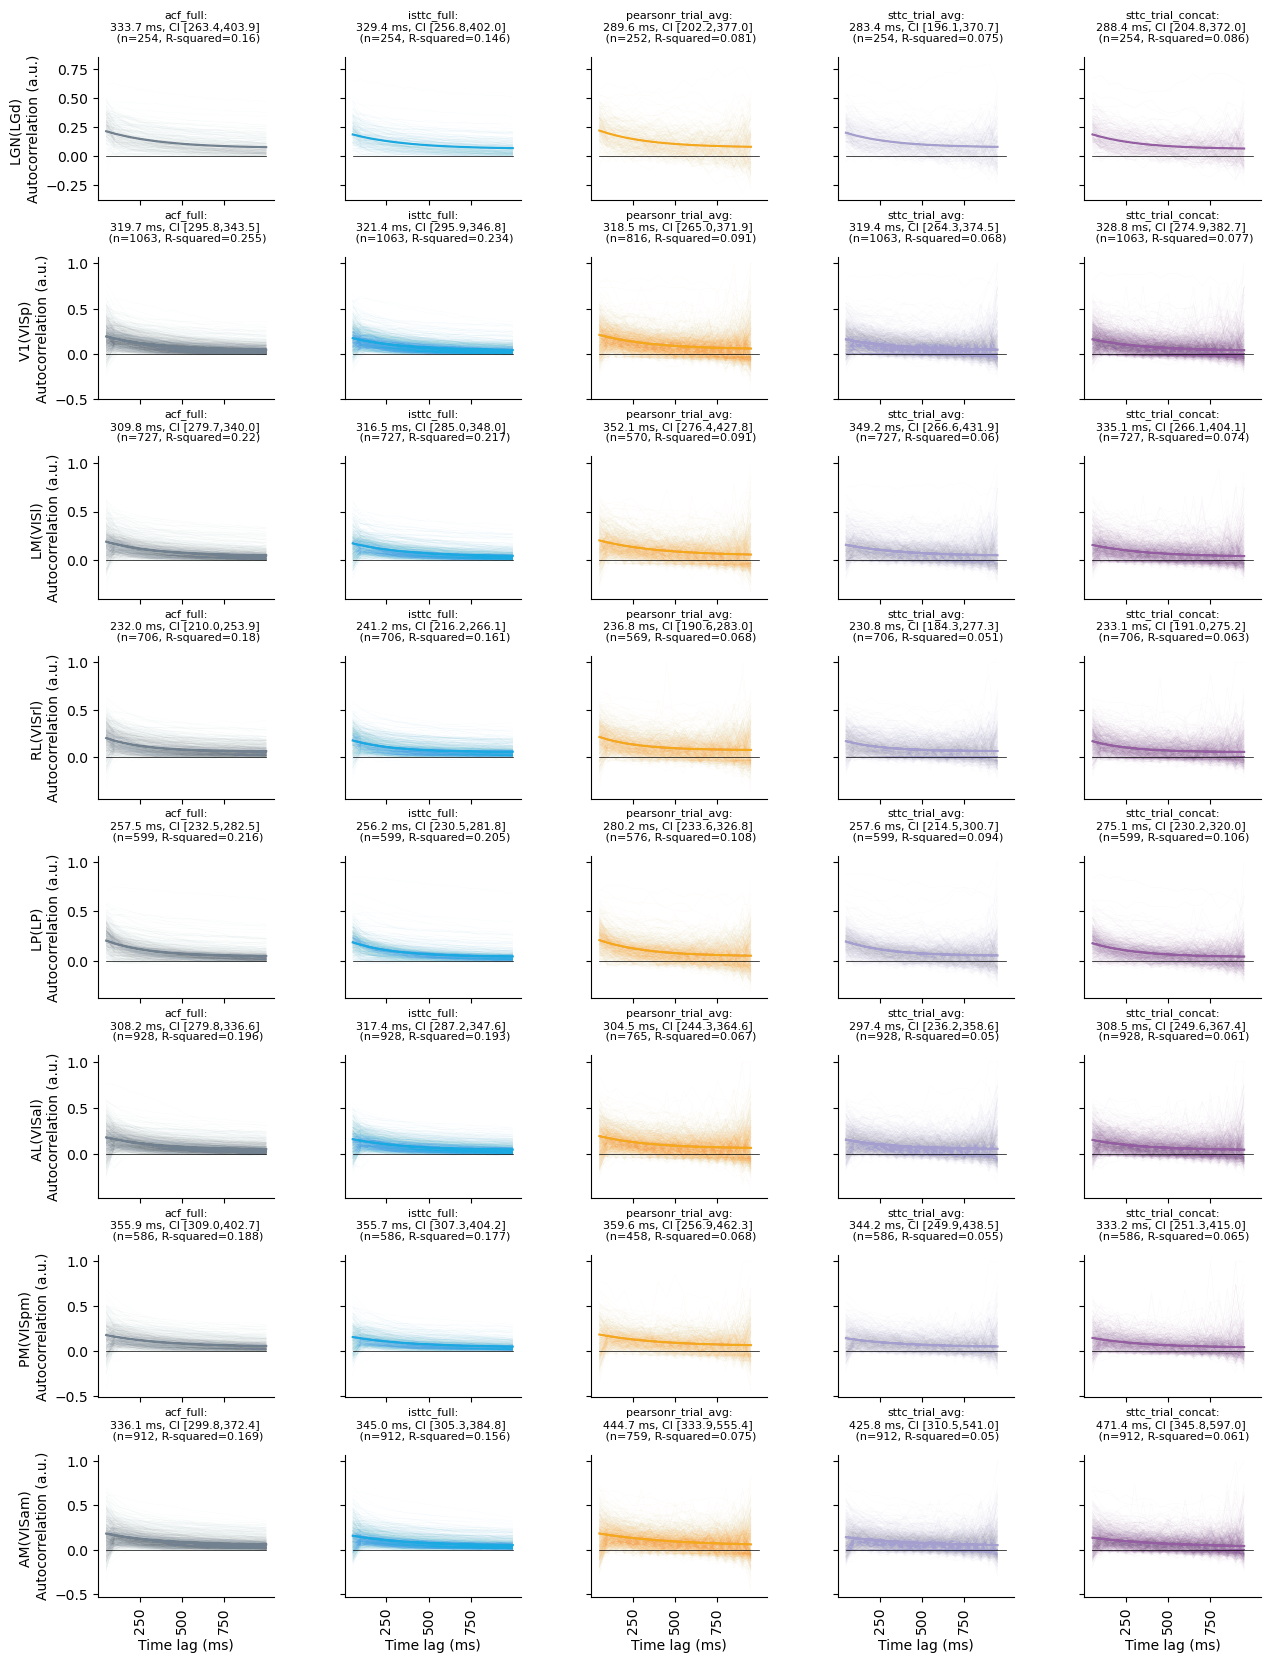

In [14]:
fig, axes = plt.subplots(8,5, figsize=(15,20), sharey='row')
plt.subplots_adjust(hspace=0.4, wspace=0.4)

t = np.linspace(1, n_lags, n_lags).astype(int)
#t_labels = np.linspace(50, 1000, n_lags).astype(int)

for area_idx, area in enumerate(brain_areas_axes_ticks):
    plot_area_method(axes[area_idx,0], area_taus_dict['acf_full'][area], 
                     acf_full_df.query('ecephys_structure_acronym == @area')[acf_cols].values, 
                     t, 'acf_full', 
                     color_acf_full)

for area_idx, area in enumerate(brain_areas_axes_ticks):
    plot_area_method(axes[area_idx,1], area_taus_dict['isttc_full'][area], 
                     acf_isttc_full_df.query('ecephys_structure_acronym == @area')[acf_cols].values, 
                     t, 'isttc_full',
                     color_isttc_full)
    
for area_idx, area in enumerate(brain_areas_axes_ticks):
    plot_area_method(axes[area_idx,2], area_taus_dict['pearsonr_trial_avg_random'][area], 
                     pearsonr_trial_avg_acf_random_df.query('ecephys_structure_acronym == @area')[acf_cols[:-1]].values, 
                     t[:-1], 'pearsonr_trial_avg',
                     color_pearson_trail_avg)

for area_idx, area in enumerate(brain_areas_axes_ticks):
    plot_area_method(axes[area_idx,3], area_taus_dict['sttc_trial_avg_random'][area], 
                     sttc_trial_avg_acf_random_df.query('ecephys_structure_acronym == @area')[acf_cols[:-1]].values, 
                     t[:-1], 'sttc_trial_avg',
                     color_sttc_trail_avg)

for area_idx, area in enumerate(brain_areas_axes_ticks):
    plot_area_method(axes[area_idx,4], area_taus_dict['sttc_trial_concat_random'][area], 
                     sttc_trial_concat_acf_random_df.query('ecephys_structure_acronym == @area')[acf_cols[:-1]].values, 
                     t[:-1], 'sttc_trial_concat',
                     color_sttc_trail_concat)

for area_idx, area in enumerate(brain_areas_axes_ticks):
    axes[area_idx, 0].set_ylabel(f'{brain_areas_names[area_idx]}({area}) \nAutocorrelation (a.u.)')


for ax in axes.flat: 
    ax.plot(t, np.zeros(len(t)), lw=0.5, c='k')
    ax.set_xticks([5, 10, 15])
    ax.set_xticklabels([])
    sns.despine(ax=ax)

for ii in range(5):
    axes[7, ii].set_xticks([5, 10, 15])
    axes[7, ii].set_xticklabels([250, 500, 750], rotation=90)
    axes[7, ii].set_xlabel('Time lag (ms)')

if save_fig:
    fig.savefig(fig_folder + 'acfs_taus_per_area_5methods_plot_per_method_trials_random.png', bbox_inches='tight', dpi=300)
    fig.savefig(fig_folder + 'acfs_taus_per_area_5methods_plot_per_method_trials_random.svg', bbox_inches='tight')

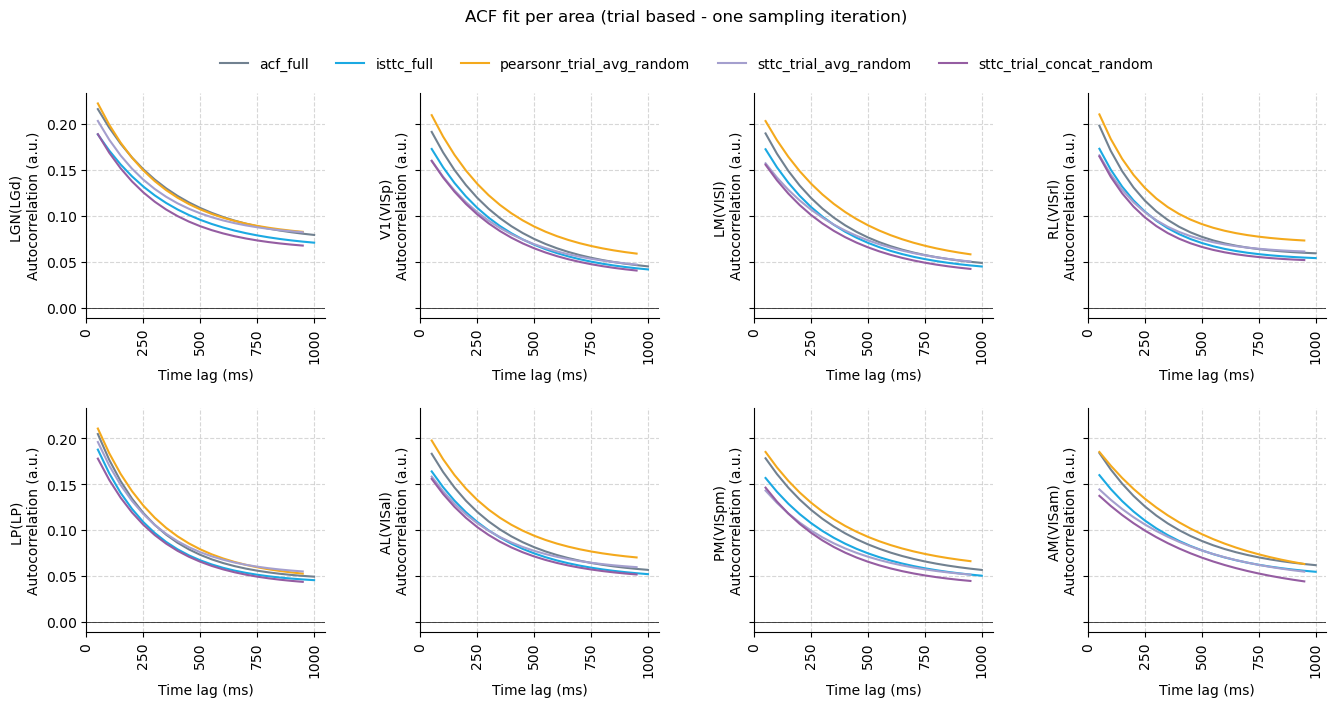

In [10]:
# plot only fit (without individual traces)

fig, axes = plt.subplots(2, 4, figsize=(16, 7), sharey=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

t = np.linspace(1, n_lags, n_lags).astype(int)

for area_idx, area in enumerate(brain_areas_axes_ticks):
    y_idx = area_idx % 4 
    x_idx = area_idx // 4
    if not np.isnan(area_taus_dict['acf_full'][area]['tau_ms']):
        axes[x_idx,y_idx].plot(t, func_single_exp_monkey(t, *area_taus_dict['acf_full'][area]['popt']), color=color_acf_full, label='acf_full')
    if not np.isnan(area_taus_dict['isttc_full'][area]['tau_ms']):
        axes[x_idx,y_idx].plot(t, func_single_exp_monkey(t, *area_taus_dict['isttc_full'][area]['popt']), color=color_isttc_full, label='isttc_full')
    if not np.isnan(area_taus_dict['pearsonr_trial_avg_random'][area]['tau_ms']):
        axes[x_idx,y_idx].plot(t[:-1], func_single_exp_monkey(t[:-1], *area_taus_dict['pearsonr_trial_avg_random'][area]['popt']), 
                               color=color_pearson_trail_avg, label='pearsonr_trial_avg_random')
    if not np.isnan(area_taus_dict['sttc_trial_avg_random'][area]['tau_ms']):
        axes[x_idx,y_idx].plot(t[:-1], func_single_exp_monkey(t[:-1], *area_taus_dict['sttc_trial_avg_random'][area]['popt']), 
                               color=color_sttc_trail_avg, label='sttc_trial_avg_random')
    if not np.isnan(area_taus_dict['sttc_trial_concat_random'][area]['tau_ms']):
        axes[x_idx,y_idx].plot(t[:-1], func_single_exp_monkey(t[:-1], *area_taus_dict['sttc_trial_concat_random'][area]['popt']), 
                               color=color_sttc_trail_concat, label='sttc_trial_concat_random')
    axes[x_idx,y_idx].set_ylabel(f'{brain_areas_names[area_idx]}({area}) \nAutocorrelation (a.u.)')

fig.suptitle('ACF fit per area (trial based - one sampling iteration)', y=1)

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), frameon=False, fontsize='medium', bbox_to_anchor=(0.5, 0.95))

for ax in axes.flat: 
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.axhline(y=0, lw=0.5, c='k')
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.set_xticklabels([0, 250, 500, 750, 1000], rotation=90)
    ax.set_xlabel('Time lag (ms)')
    sns.despine(ax=ax)

if save_fig:
    fig.savefig(fig_folder + 'acf_fit_per_area_5methods_plot_per_method_trials_random.png', bbox_inches='tight', dpi=300)
    fig.savefig(fig_folder + 'acf_fit_per_area_5methods_plot_per_method_trials_random.svg', bbox_inches='tight')

#### Per method with confidence intervals

In [15]:
def get_plot_df(acf_dict, areas, method):
    tau = [acf_dict.get(c, {'tau_ms': np.nan})['tau_ms'] for c in areas]
    tau_lower = [acf_dict.get(c, {'tau_lower_ms': np.nan})['tau_lower_ms'] for c in areas]
    tau_upper = [acf_dict.get(c, {'tau_upper_ms': np.nan})['tau_upper_ms'] for c in areas]
    
    plot_df = pd.DataFrame({'area': areas, 
                                     'tau': tau,
                                     'tau_lower': tau_lower, 
                                     'tau_upper': tau_upper, 
                                     'method': method})
    return plot_df

In [16]:
# trial_postfix_ '_mean', '_random', ''
def plot_per_method(area_taus_dict_, brain_areas_axes_ticks_, trial_postfix_):
    
    acf_full_plot_df = get_plot_df(area_taus_dict_['acf_full'], brain_areas_axes_ticks_, 'acf_full')
    acf_isttc_full_plot_df = get_plot_df(area_taus_dict_['isttc_full'], brain_areas_axes_ticks_, 'isttc_full')
    pearsonr_trial_avg_plot_df = get_plot_df(area_taus_dict['pearsonr_trial_avg'+trial_postfix_], brain_areas_axes_ticks, 'pearsonr_trial_avg')
    sttc_trial_avg_plot_df = get_plot_df(area_taus_dict['sttc_trial_avg'+trial_postfix_], brain_areas_axes_ticks, 'sttc_trial_avg')
    sttc_trial_concat_plot_df = get_plot_df(area_taus_dict['sttc_trial_concat'+trial_postfix_], brain_areas_axes_ticks, 'sttc_trial_concat')

    acf_full_error_bars = [acf_full_plot_df['tau'].values - acf_full_plot_df['tau_lower'].values, 
                       acf_full_plot_df['tau_upper'].values - acf_full_plot_df['tau'].values]
    acf_isttc_full_error_bars = [acf_isttc_full_plot_df['tau'].values - acf_isttc_full_plot_df['tau_lower'].values, 
                           acf_isttc_full_plot_df['tau_upper'].values - acf_isttc_full_plot_df['tau'].values ]
    pearsonr_trial_avg_full_error_bars = [pearsonr_trial_avg_plot_df['tau'].values - pearsonr_trial_avg_plot_df['tau_lower'].values, 
                           pearsonr_trial_avg_plot_df['tau_upper'].values - pearsonr_trial_avg_plot_df['tau'].values ]
    sttc_trial_avg_full_error_bars = [sttc_trial_avg_plot_df['tau'].values - sttc_trial_avg_plot_df['tau_lower'].values, 
                           sttc_trial_avg_plot_df['tau_upper'].values - sttc_trial_avg_plot_df['tau'].values ]
    sttc_trial_concat_full_error_bars = [sttc_trial_concat_plot_df['tau'].values - sttc_trial_concat_plot_df['tau_lower'].values, 
                           sttc_trial_concat_plot_df['tau_upper'].values - sttc_trial_concat_plot_df['tau'].values ]
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 5), sharey=False)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    
    for i, (cond, tau, err_low, err_high) in enumerate(zip(brain_areas_axes_ticks, acf_full_plot_df['tau'].values, 
                                                           acf_full_error_bars[0], acf_full_error_bars[1])):
        axes[0,0].errorbar(cond, tau, yerr=[[err_low], [err_high]], fmt='o', capsize=5, capthick=2, markersize=8, color='slategray')
    axes[0,0].set_xticks(brain_areas_axes_ticks)
    axes[0,0].set_xticklabels(brain_areas_names)
    axes[0,0].set_title('ACF full, 95% CI')
    
    for i, (cond, tau, err_low, err_high) in enumerate(zip(brain_areas_axes_ticks, acf_isttc_full_plot_df['tau'].values, 
                                                           acf_isttc_full_error_bars[0], acf_isttc_full_error_bars[1])):
        axes[0,1].errorbar(cond, tau, yerr=[[err_low], [err_high]], fmt='o', capsize=5, capthick=2, markersize=8, color='slategray')
    axes[0,1].set_xticks(brain_areas_axes_ticks)
    axes[0,1].set_xticklabels(brain_areas_names)
    axes[0,1].set_title('ACF iSTTC full, 95% CI')
    
    axes[0,2].set_axis_off()
    
    for i, (cond, tau, err_low, err_high) in enumerate(zip(brain_areas_axes_ticks, pearsonr_trial_avg_plot_df['tau'].values, 
                                                           pearsonr_trial_avg_full_error_bars[0], pearsonr_trial_avg_full_error_bars[1])):
        axes[1,0].errorbar(cond, tau, yerr=[[err_low], [err_high]], fmt='o', capsize=5, capthick=2, markersize=8, color='slategray')
    axes[1,0].set_title('Pearsonr trial avg, 95% CI')
    axes[1,0].set_xticks(brain_areas_axes_ticks)
    axes[1,0].set_xticklabels(brain_areas_names)
    
    for i, (cond, tau, err_low, err_high) in enumerate(zip(brain_areas_axes_ticks, sttc_trial_avg_plot_df['tau'].values, 
                                                           sttc_trial_avg_full_error_bars[0], sttc_trial_avg_full_error_bars[1])):
        axes[1,1].errorbar(cond, tau, yerr=[[err_low], [err_high]], fmt='o', capsize=5, capthick=2, markersize=8, color='slategray')
    axes[1,1].set_title('STTC trial avg, 95% CI')
    axes[1,1].set_xticks(brain_areas_axes_ticks)
    axes[1,1].set_xticklabels(brain_areas_names)
    
    for i, (cond, tau, err_low, err_high) in enumerate(zip(brain_areas_axes_ticks, sttc_trial_concat_plot_df['tau'].values, 
                                                           sttc_trial_concat_full_error_bars[0], sttc_trial_concat_full_error_bars[1])):
        axes[1,2].errorbar(cond, tau, yerr=[[err_low], [err_high]], fmt='o', capsize=5, capthick=2, markersize=8, color='slategray')
    axes[1,2].set_title('STTC trial concat, 95% CI')
    axes[1,2].set_xticks(brain_areas_axes_ticks)
    axes[1,2].set_xticklabels(brain_areas_names)
    
    for ax in axes.flat:
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_ylabel('Intrinsic timescale (ms)')
        # ax.set_xticklabels(['Pearson trial avg', 'STTC trial avg', 'STTC trial concat', 'Fascianelli et al.2019 \n Figure 2'], 
        #                    rotation=45, ha='right', fontsize=8)
        ax.set_xlim([-0.5, 7.5])
        
    
    sns.despine()
    
    if save_fig:
        fig.savefig(fig_folder + 'tau_per_area_5methods_plot_per_method_' + trial_postfix_ + '.png', bbox_inches='tight', dpi=300)
        fig.savefig(fig_folder + 'tau_per_area_5methods_plot_per_method_' + trial_postfix_ + '.svg', bbox_inches='tight')

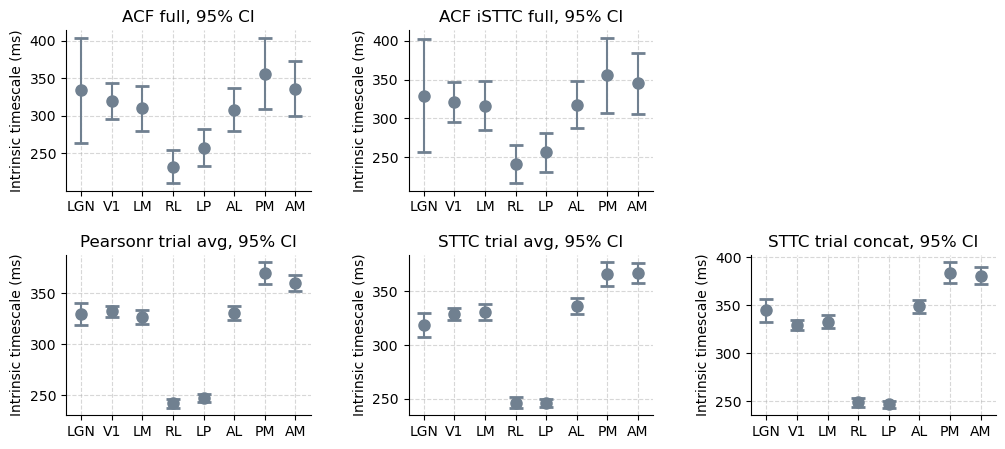

In [17]:
plot_per_method(area_taus_dict, brain_areas_axes_ticks, '')

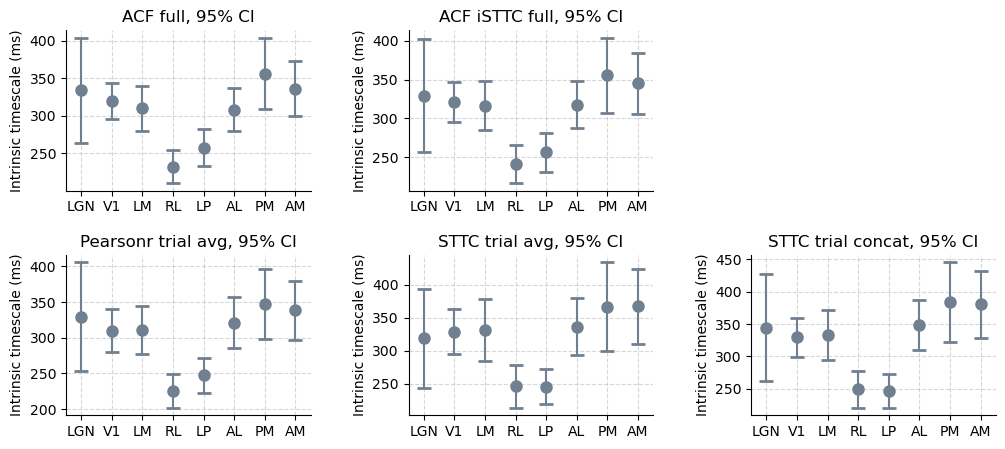

In [18]:
plot_per_method(area_taus_dict, brain_areas_axes_ticks, '_mean')

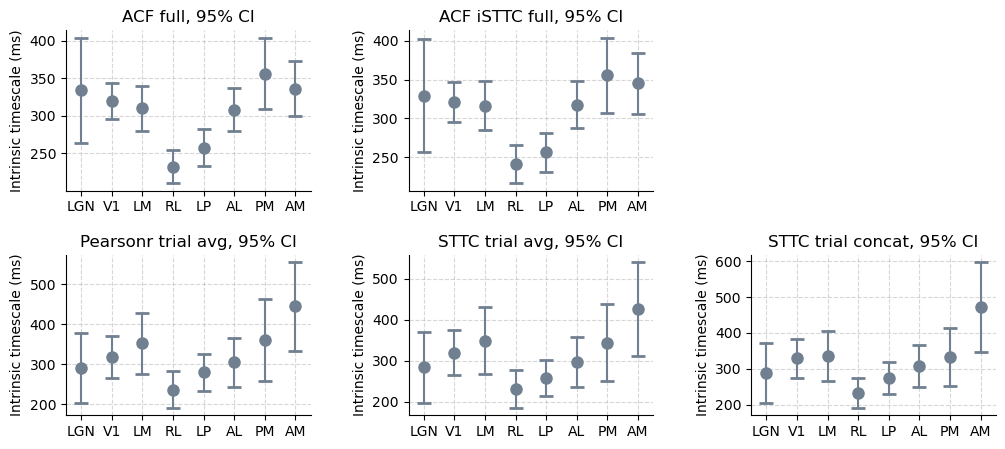

In [19]:
plot_per_method(area_taus_dict, brain_areas_axes_ticks, '_random')

#### Per area with confidence intervals

In [20]:
methods = ['acf_full', 'isttc_full', 'pearsonr_trial_avg','sttc_trial_avg', 'sttc_trial_concat']

In [21]:
def get_brain_area_df(plot_df_all_areas, area):
    area_df = plot_df_all_areas.query('area == @area').copy()
    area_df['method'] = pd.Categorical(area_df['method'], 
                                       categories=methods, ordered=True)
    area_df_ordered = area_df.sort_values(by='method')

    acf_full_error_bars = [area_df_ordered['tau'].values - area_df_ordered['tau_lower'].values, 
                       area_df_ordered['tau_upper'].values - area_df_ordered['tau'].values]

    return area_df_ordered, acf_full_error_bars

In [22]:
def plot_per_area(trial_postfix_):

    acf_full_plot_df = get_plot_df(area_taus_dict['acf_full'], brain_areas_axes_ticks, 'acf_full')
    acf_isttc_full_plot_df = get_plot_df(area_taus_dict['isttc_full'], brain_areas_axes_ticks, 'isttc_full')
    pearsonr_trial_avg_plot_df = get_plot_df(area_taus_dict['pearsonr_trial_avg'+trial_postfix_], brain_areas_axes_ticks, 'pearsonr_trial_avg')
    sttc_trial_avg_plot_df = get_plot_df(area_taus_dict['sttc_trial_avg'+trial_postfix_], brain_areas_axes_ticks, 'sttc_trial_avg')
    sttc_trial_concat_plot_df = get_plot_df(area_taus_dict['sttc_trial_concat'+trial_postfix_], brain_areas_axes_ticks, 'sttc_trial_concat')
    
    plot_df_concat = pd.concat([acf_full_plot_df, 
                                acf_isttc_full_plot_df, 
                                pearsonr_trial_avg_plot_df, 
                                sttc_trial_avg_plot_df, 
                                sttc_trial_concat_plot_df])
    plot_df_concat.reset_index(inplace=True, drop=True)
    
    fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharey=False)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    
    for i in range(4):
        area_df_ordered, error_bars = get_brain_area_df(plot_df_concat, brain_areas_axes_ticks[i])
        for j, (cond, tau, err_low, err_high) in enumerate(zip(methods, area_df_ordered['tau'].values, 
                                                               error_bars[0], error_bars[1])):
            axes[0,i].errorbar(cond, tau, yerr=[[err_low], [err_high]], fmt='o', capsize=5, capthick=2, markersize=6, color='slategray')
            axes[0,i].set_title(f'{brain_areas_names[i]}({brain_areas_axes_ticks[i]})')
    
    for i in range(4, 8):
        area_df_ordered, error_bars = get_brain_area_df(plot_df_concat, brain_areas_axes_ticks[i])
        for jj, (cond, tau, err_low, err_high) in enumerate(zip(methods, area_df_ordered['tau'].values, 
                                                               error_bars[0], error_bars[1])):
            axes[1,i-4].errorbar(cond, tau, yerr=[[err_low], [err_high]], fmt='o', capsize=5, capthick=2, markersize=6, color='slategray')
            axes[1,i-4].set_title(f'{brain_areas_names[i]}({brain_areas_axes_ticks[i]})')
       
    axes[0,0].set_ylabel('Intrinsic timescale (ms)', fontsize=8)
    axes[1,0].set_ylabel('Intrinsic timescale (ms)', fontsize=8)
    
    for ax in axes.flat:
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xticks(['acf_full', 'isttc_full', 'pearsonr_trial_avg','sttc_trial_avg', 'sttc_trial_concat'])
        ax.set_xticklabels([])
        ax.set_xlim([-0.5, 4.5])
    
    for ax in axes.flat[4:]:
        ax.set_xticks(['acf_full', 'isttc_full', 'pearsonr_trial_avg','sttc_trial_avg', 'sttc_trial_concat'])
        ax.set_xticklabels(['ACF full', 'iSTTC full', 'Pearson trial avg', 'STTC trial avg', 'STTC trial concat'], 
                           rotation=45, ha='right', fontsize=8)
    
    #plt.subplots_adjust(left=.5) 
        
    sns.despine()
    
    if save_fig:
        fig.savefig(fig_folder + 'tau_per_area_5methods_' + trial_postfix_ + '.png', bbox_inches='tight', dpi=300)
        fig.savefig(fig_folder + 'tau_per_area_5methods_' + trial_postfix_ + '.svg', bbox_inches='tight')

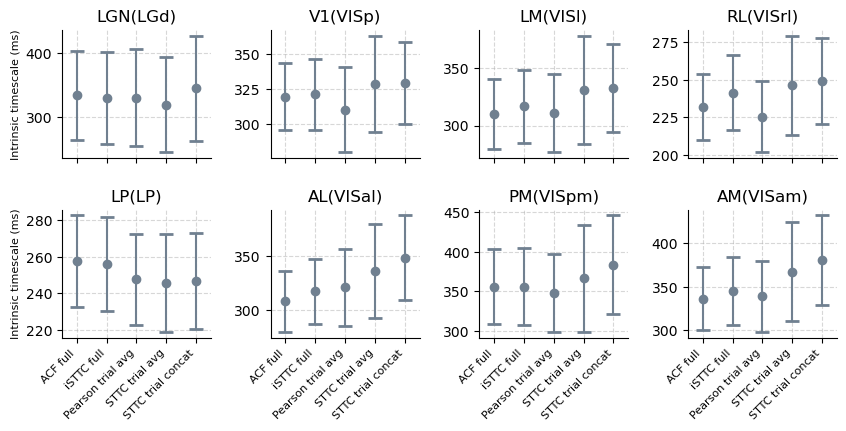

In [23]:
plot_per_area('_mean')

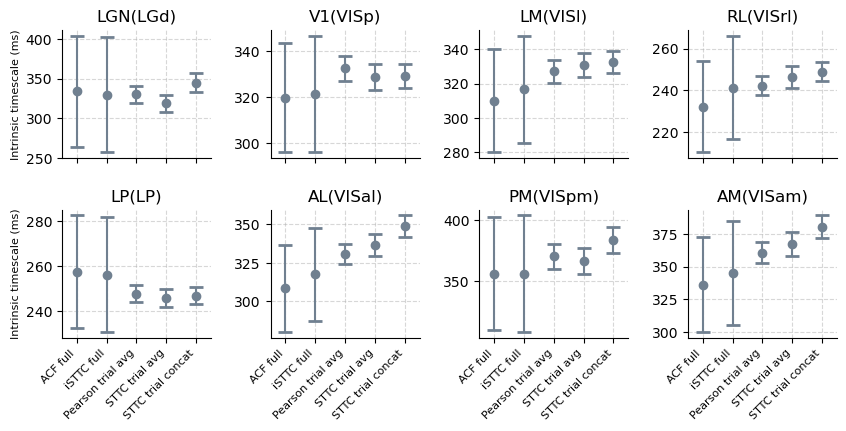

In [24]:
plot_per_area('')

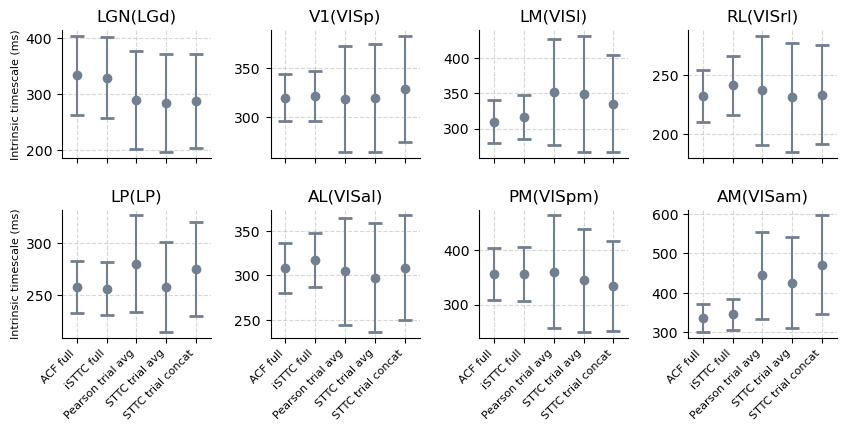

In [25]:
plot_per_area('_random')

#### Plot taus using heatmap

In [26]:
def plot_tau_per_area_heatmap(trial_postfix_):
    acf_full_plot_df = get_plot_df(area_taus_dict['acf_full'], brain_areas_axes_ticks, 'acf_full')
    acf_isttc_full_plot_df = get_plot_df(area_taus_dict['isttc_full'], brain_areas_axes_ticks, 'isttc_full')
    pearsonr_trial_avg_plot_df = get_plot_df(area_taus_dict['pearsonr_trial_avg'+trial_postfix_], brain_areas_axes_ticks, 'pearsonr_trial_avg')
    sttc_trial_avg_plot_df = get_plot_df(area_taus_dict['sttc_trial_avg'+trial_postfix_], brain_areas_axes_ticks, 'sttc_trial_avg')
    sttc_trial_concat_plot_df = get_plot_df(area_taus_dict['sttc_trial_concat'+trial_postfix_], brain_areas_axes_ticks, 'sttc_trial_concat')
    
    plot_df_concat = pd.concat([acf_full_plot_df, 
                                acf_isttc_full_plot_df, 
                                pearsonr_trial_avg_plot_df, 
                                sttc_trial_avg_plot_df, 
                                sttc_trial_concat_plot_df])
    plot_df_concat.reset_index(inplace=True, drop=True)

    heatmap_plot_df_concat = plot_df_concat.pivot(index='method', columns='area', values='tau')
    sorted_columns = heatmap_plot_df_concat.loc['isttc_full'].sort_values(ascending=True).index
    heatmap_plot_df_concat_sorted = heatmap_plot_df_concat[sorted_columns]

    fig, axes = plt.subplots(1, 1, figsize=(5, 4), sharey=False)

    sns.heatmap(heatmap_plot_df_concat_sorted, annot=True, fmt=".0f", cmap="magma", ax=axes)
    axes.set_ylabel('Method')
    axes.set_xlabel('Area')

    axes.set_xticklabels([f"{brain_areas_names[brain_areas_axes_ticks.index(col)]}({col})" for col in sorted_columns],
                         rotation=45, ha='right')

    if save_fig:
        fig.savefig(fig_folder + 'tau_per_area_5methods_heatmap_' + trial_postfix_ + '.png', bbox_inches='tight', dpi=300)
        fig.savefig(fig_folder + 'tau_per_area_5methods_heatmap_' + trial_postfix_ + '.svg', bbox_inches='tight')


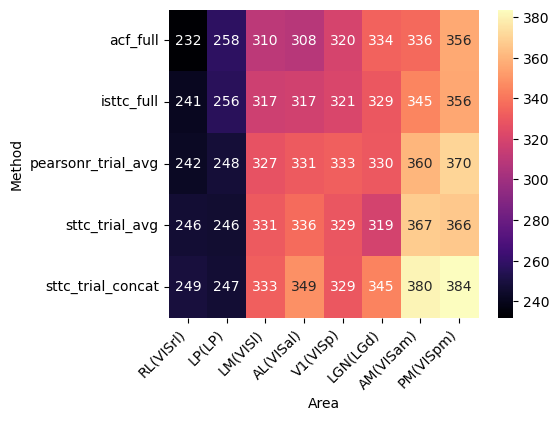

In [27]:
plot_tau_per_area_heatmap('')

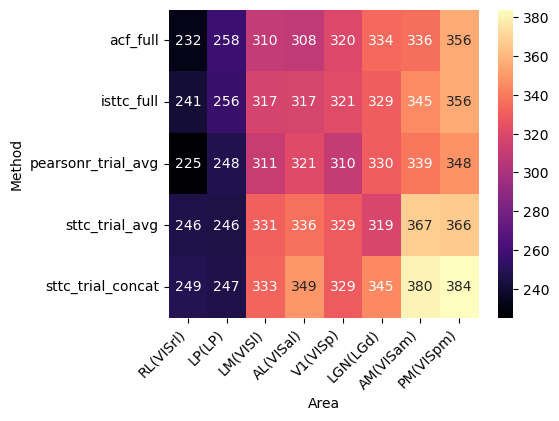

In [28]:
plot_tau_per_area_heatmap('_mean')

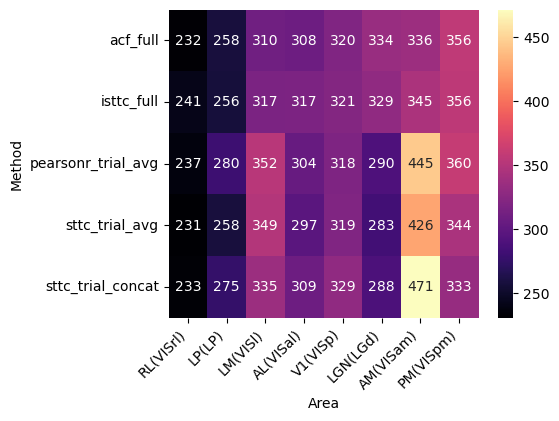

In [29]:
plot_tau_per_area_heatmap('_random')

In [30]:
def plot_tau_diff_per_area_heatmap(trial_postfix_):
    acf_full_plot_df = get_plot_df(area_taus_dict['acf_full'], brain_areas_axes_ticks, 'acf_full')
    acf_isttc_full_plot_df = get_plot_df(area_taus_dict['isttc_full'], brain_areas_axes_ticks, 'isttc_full')
    pearsonr_trial_avg_plot_df = get_plot_df(area_taus_dict['pearsonr_trial_avg'+trial_postfix_], brain_areas_axes_ticks, 'pearsonr_trial_avg')
    sttc_trial_avg_plot_df = get_plot_df(area_taus_dict['sttc_trial_avg'+trial_postfix_], brain_areas_axes_ticks, 'sttc_trial_avg')
    sttc_trial_concat_plot_df = get_plot_df(area_taus_dict['sttc_trial_concat'+trial_postfix_], brain_areas_axes_ticks, 'sttc_trial_concat')
    
    plot_df_concat = pd.concat([acf_full_plot_df, 
                                acf_isttc_full_plot_df, 
                                pearsonr_trial_avg_plot_df, 
                                sttc_trial_avg_plot_df, 
                                sttc_trial_concat_plot_df])
    plot_df_concat.reset_index(inplace=True, drop=True)

    heatmap_plot_df_concat = plot_df_concat.pivot(index='method', columns='area', values='tau')
    sorted_columns = heatmap_plot_df_concat.loc['isttc_full'].sort_values(ascending=True).index
    heatmap_plot_df_concat_sorted = heatmap_plot_df_concat[sorted_columns]

    # Subtract 'acf_full' from all rows (broadcast across columns)
    diff_df = heatmap_plot_df_concat_sorted.subtract(heatmap_plot_df_concat_sorted.loc['acf_full'], axis=1)
    # Drop the acf_full row itself, since it's the baseline (diff = 0)
    diff_df = diff_df.drop(index='acf_full')
    diff_long = diff_df.reset_index().melt(id_vars='method', var_name='area', value_name='tau_diff')

    fig, axes = plt.subplots(1, 1, figsize=(7, 3), sharey=False)

    sns.heatmap(diff_df, annot=True, fmt=".1f", center=0, cmap="coolwarm", linewidths=0, ax=axes)
    axes.set_ylabel('Method')
    axes.set_xlabel('Area')

    axes.set_xticklabels([f"{brain_areas_names[brain_areas_axes_ticks.index(col)]}({col})" for col in sorted_columns],
                     rotation=45, ha='right')

    if save_fig:
        fig.savefig(fig_folder + 'tau_per_area_5methods_heatmap_diff_' + trial_postfix_ + '.png', bbox_inches='tight', dpi=300)
        fig.savefig(fig_folder + 'tau_per_area_5methods_heatmap_diff_' + trial_postfix_ + '.svg', bbox_inches='tight')

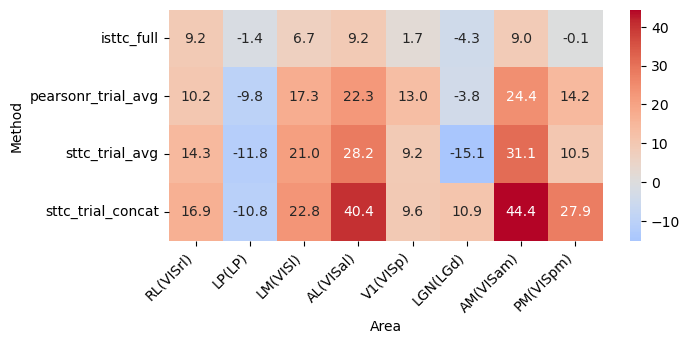

In [31]:
plot_tau_diff_per_area_heatmap('')

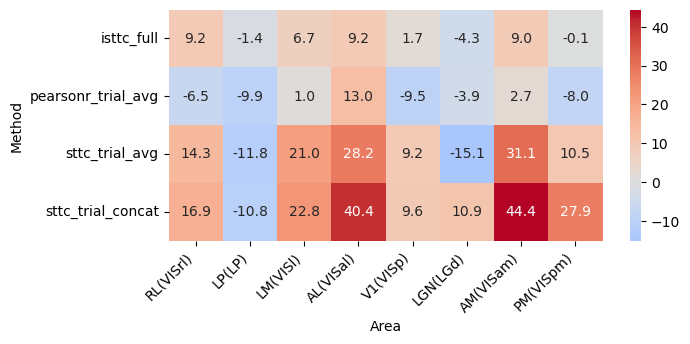

In [32]:
plot_tau_diff_per_area_heatmap('_mean')

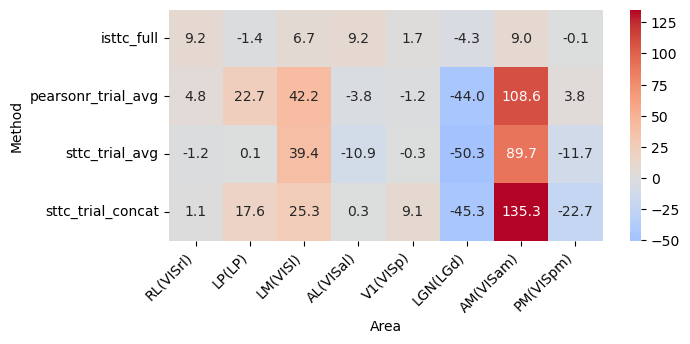

In [33]:
plot_tau_diff_per_area_heatmap('_random')

In [34]:
def plot_tau_diff_per_area_stripplot(trial_postfix_):
    acf_full_plot_df = get_plot_df(area_taus_dict['acf_full'], brain_areas_axes_ticks, 'acf_full')
    acf_isttc_full_plot_df = get_plot_df(area_taus_dict['isttc_full'], brain_areas_axes_ticks, 'isttc_full')
    pearsonr_trial_avg_plot_df = get_plot_df(area_taus_dict['pearsonr_trial_avg'+trial_postfix_], brain_areas_axes_ticks, 'pearsonr_trial_avg')
    sttc_trial_avg_plot_df = get_plot_df(area_taus_dict['sttc_trial_avg'+trial_postfix_], brain_areas_axes_ticks, 'sttc_trial_avg')
    sttc_trial_concat_plot_df = get_plot_df(area_taus_dict['sttc_trial_concat'+trial_postfix_], brain_areas_axes_ticks, 'sttc_trial_concat')
    
    plot_df_concat = pd.concat([acf_full_plot_df, 
                                acf_isttc_full_plot_df, 
                                pearsonr_trial_avg_plot_df, 
                                sttc_trial_avg_plot_df, 
                                sttc_trial_concat_plot_df])
    plot_df_concat.reset_index(inplace=True, drop=True)

    heatmap_plot_df_concat = plot_df_concat.pivot(index='method', columns='area', values='tau')
    sorted_columns = heatmap_plot_df_concat.loc['isttc_full'].sort_values(ascending=True).index
    heatmap_plot_df_concat_sorted = heatmap_plot_df_concat[sorted_columns]

    # Subtract 'acf_full' from all rows (broadcast across columns)
    diff_df = heatmap_plot_df_concat_sorted.subtract(heatmap_plot_df_concat_sorted.loc['acf_full'], axis=1)
    # Drop the acf_full row itself, since it's the baseline (diff = 0)
    diff_df = diff_df.drop(index='acf_full')
    diff_long = diff_df.reset_index().melt(id_vars='method', var_name='area', value_name='tau_diff')

    fig, axes = plt.subplots(1, 1, figsize=(7, 3), sharey=False)

    sns.stripplot(data=diff_long, x='method', y='tau_diff', jitter=True, alpha=0.7, ax=axes)
    axes.axhline(0, color='gray', linestyle='--')
    
    axes.set_ylabel('Tau Difference')
    axes.set_xlabel('Method')
    #axes.set_xticklabels(rotation=45, ha='right', fontsize=8)
    
    axes.set_xticks(['isttc_full', 'pearsonr_trial_avg','sttc_trial_avg', 'sttc_trial_concat'])
    axes.set_xticklabels(['iSTTC full', 'Pearson trial avg', 'STTC trial avg', 'STTC trial concat'], 
                       rotation=45, ha='right', fontsize=8)

    sns.despine(ax=axes)

    if save_fig:
        fig.savefig(fig_folder + 'tau_per_area_5methods_stripplot_diff_' + trial_postfix_ + '.png', bbox_inches='tight', dpi=300)
        fig.savefig(fig_folder + 'tau_per_area_5methods_stripplot_diff_' + trial_postfix_ + '.svg', bbox_inches='tight')

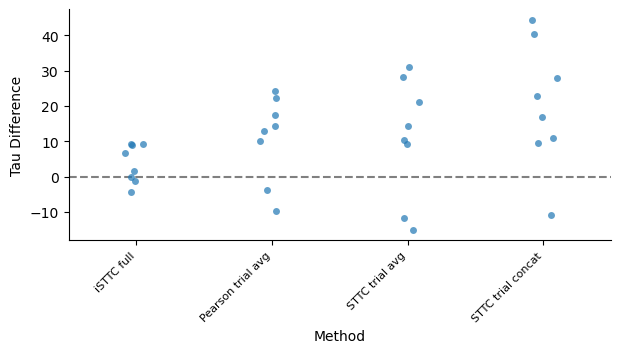

In [35]:
plot_tau_diff_per_area_stripplot('')

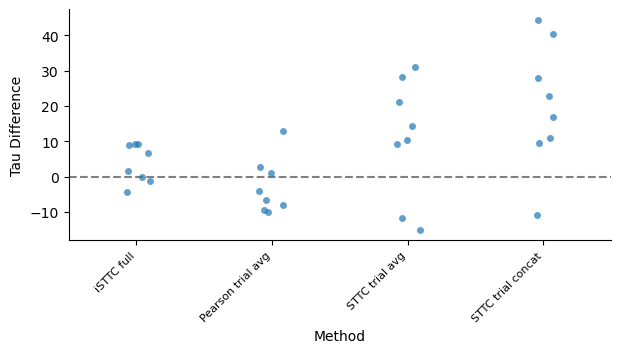

In [36]:
plot_tau_diff_per_area_stripplot('_mean')

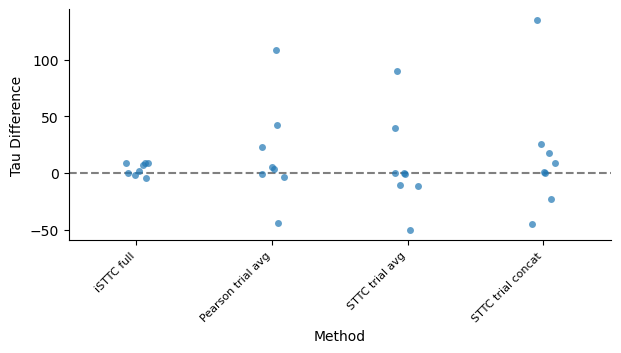

In [37]:
plot_tau_diff_per_area_stripplot('_random')

#### Plot vs anatomical hierarchy

In [49]:
hierarchy_score = {'LGd' : -0.515,
                   'VISp' : -0.357,
                   'VISl' : -0.093,
                   'VISrl' : -0.059,
                   'LP' : 0.105,
                   'VISal' : 0.152,
                   'VISpm' : 0.327,
                   'VISam' : 0.441}

In [50]:
trial_postfix_='_random'

acf_full_plot_df = get_plot_df(area_taus_dict['acf_full'], brain_areas_axes_ticks, 'acf_full')
acf_isttc_full_plot_df = get_plot_df(area_taus_dict['isttc_full'], brain_areas_axes_ticks, 'isttc_full')
pearsonr_trial_avg_plot_df = get_plot_df(area_taus_dict['pearsonr_trial_avg'+trial_postfix_], brain_areas_axes_ticks, 'pearsonr_trial_avg')
sttc_trial_avg_plot_df = get_plot_df(area_taus_dict['sttc_trial_avg'+trial_postfix_], brain_areas_axes_ticks, 'sttc_trial_avg')
sttc_trial_concat_plot_df = get_plot_df(area_taus_dict['sttc_trial_concat'+trial_postfix_], brain_areas_axes_ticks, 'sttc_trial_concat')

In [44]:
acf_full_plot_df

,area,tau,tau_lower,tau_upper,method,hierarchy_score
0,LGd,333.665117,263.428446,403.901788,acf_full,-0.515
1,VISp,319.666876,295.833667,343.500085,acf_full,-0.357
2,VISl,309.833469,279.672525,339.994413,acf_full,-0.093
3,VISrl,231.960386,209.990322,253.930450,acf_full,-0.059
4,LP,257.533155,232.531661,282.534650,acf_full,0.105
5,VISal,308.236681,279.836255,336.637108,acf_full,0.152
6,VISpm,355.878467,309.013986,402.742948,acf_full,0.327
7,VISam,336.073203,299.788364,372.358042,acf_full,0.441


In [51]:
acf_full_plot_df['hierarchy_score'] = acf_full_plot_df['area'].map(hierarchy_score)
acf_isttc_full_plot_df['hierarchy_score'] = acf_isttc_full_plot_df['area'].map(hierarchy_score)
pearsonr_trial_avg_plot_df['hierarchy_score'] = pearsonr_trial_avg_plot_df['area'].map(hierarchy_score)
sttc_trial_concat_plot_df['hierarchy_score'] = sttc_trial_concat_plot_df['area'].map(hierarchy_score)

hierarchy_score_df = pd.concat([acf_full_plot_df, acf_isttc_full_plot_df, pearsonr_trial_avg_plot_df, sttc_trial_concat_plot_df])

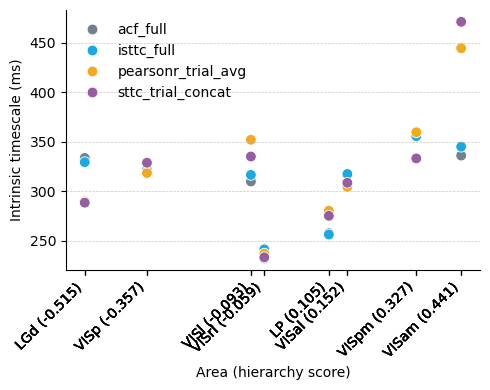

In [57]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4))

sns.scatterplot(
    x='hierarchy_score',
    y='tau',
    hue='method',
    data=hierarchy_score_df,
    palette=colors,
    s=60,
    ax=axes
)

# Sort so labels match the x positions
df_sorted = hierarchy_score_df.sort_values('hierarchy_score')

# Build labels like: VISp (-0.357)
xtick_labels = [
    f"{area} ({score:.3f})"
    for area, score in zip(df_sorted['area'], df_sorted['hierarchy_score'])
]

axes.set_xticks(df_sorted['hierarchy_score'])
axes.set_xticklabels(xtick_labels, rotation=45, ha='right')

axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
axes.set_xlabel('Area (hierarchy score)')
axes.set_ylabel('Intrinsic timescale (ms)')
axes.legend(frameon=False)

sns.despine()
plt.tight_layout()


plt.savefig(fig_folder + 'hierarchy_score_siegle.png' , bbox_inches='tight', dpi=300)
plt.savefig(fig_folder + 'hierarchy_score_siegle.svg' , bbox_inches='tight')

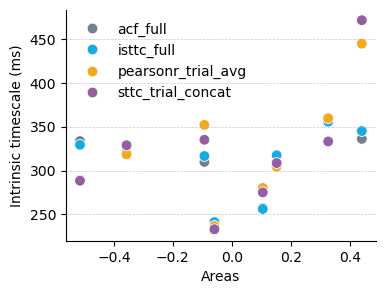

In [53]:
colors = [color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_concat]

fig, axes = plt.subplots(1,1, figsize=(4,3))

sns.scatterplot(x='hierarchy_score', y='tau', hue='method', 
                data=hierarchy_score_df, palette=colors, s=60)
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
axes.legend(frameon=False)
axes.set_xlabel('Areas')
axes.set_ylabel('Intrinsic timescale (ms)')

sns.despine()